# Demo for test functions for all kind of data processing

## Tasks:
* Detect events:
    * Pitcher:
        * first movement
        * ball release
    * Batter:
        * Foot highest, foot back to ground
        * First step (when starting to run)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sp
import scipy.stats
import json
from os import listdir
import cv2
import time
import ast
import json
from run_events import Runner
from test import test
# import matplotlib.pylab as plt
#from notebooks.code_to_json import from_json

from data_preprocess import JsonProcessor
from tools import Tools
from test import test
# path_outputs = "/Volumes/Nina Backup/finished_outputs/"
# test_json_files = "/Volumes/Nina Backup/high_quality_outputs/"
# test_data_path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"
# save =  "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/pitch_type_svcf"

# import functions:
# first_move_batter_gradient, first_move_batter_NN, release_frame_conv_net, release_frame_2Dfrom_video, foot_to_ground
from detect_event import *

In [2]:
def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

import matplotlib.pylab as plt
joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
        "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
        "right_eye", "right_ear","left_eye", "left_ear"]

## Get data

In [3]:
#csv = pd.read_csv("train_data/csv_gameplay.csv", delimiter=";")
#line = csv[csv["play_id"]=="f4ea3410-f559-464f-acb0-74133d7742e3"]
#print(line["Pitch Type"])
#print(line["Play Outcome"])

example = "demo_data/example_1" # f4ea3410-f559-464f-acb0-74133d7742e3
pitcher = from_json(example+"_pitcher.json")
batter = from_json(example+"_batter.json")
with open(example+"_video_batter.json", "r") as infile:
    videos_b = json.load(infile)
with open(example+"_video_pitcher.json", "r") as infile:
    videos_p = json.load(infile)
with open(example+"_labels.json", "r") as infile:
    labels = json.load(infile)

## Visualize pitcher and batter joints

-------------------- batter ------------------------


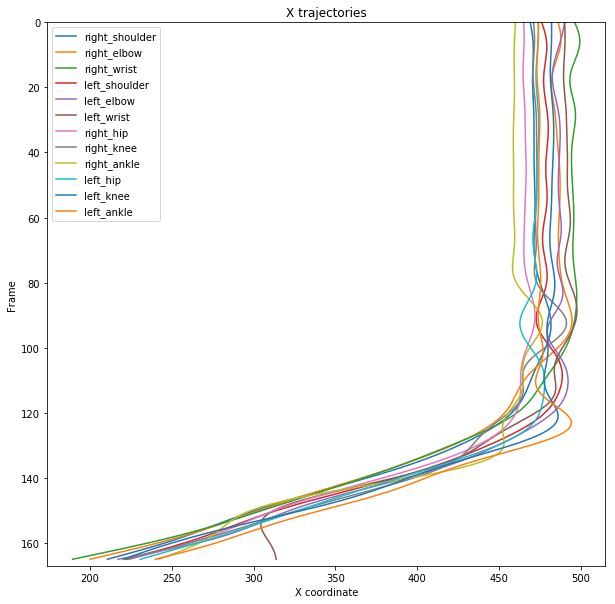

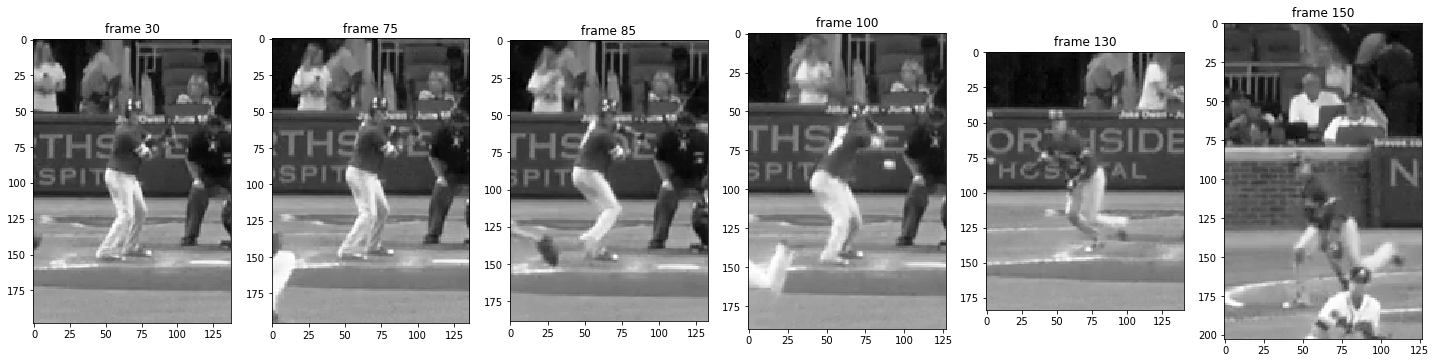

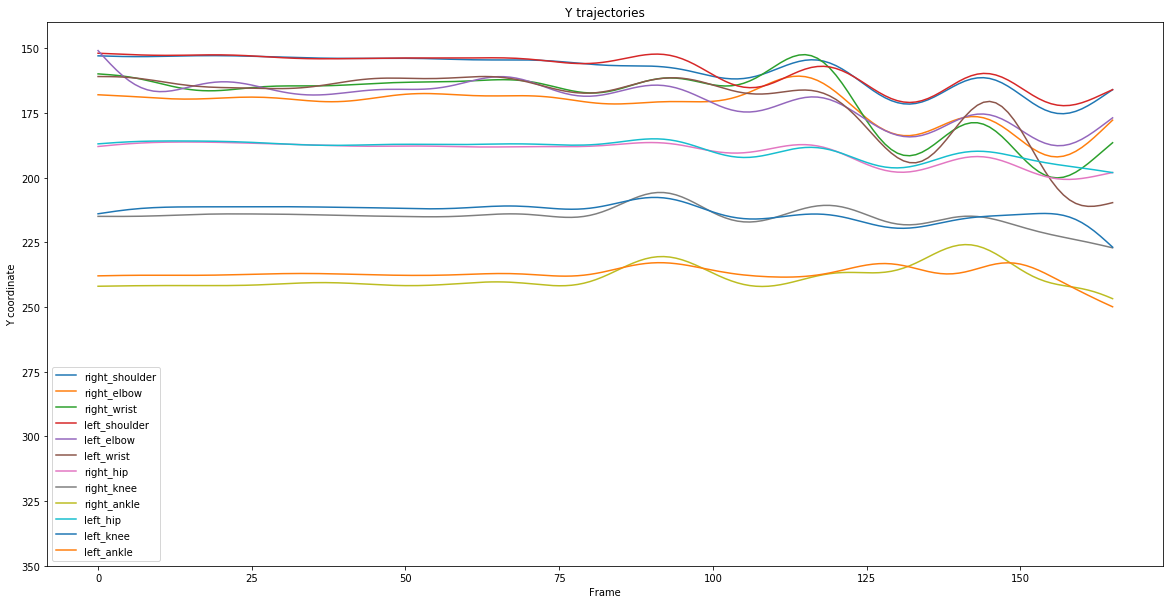

-------------------- pitcher ------------------------


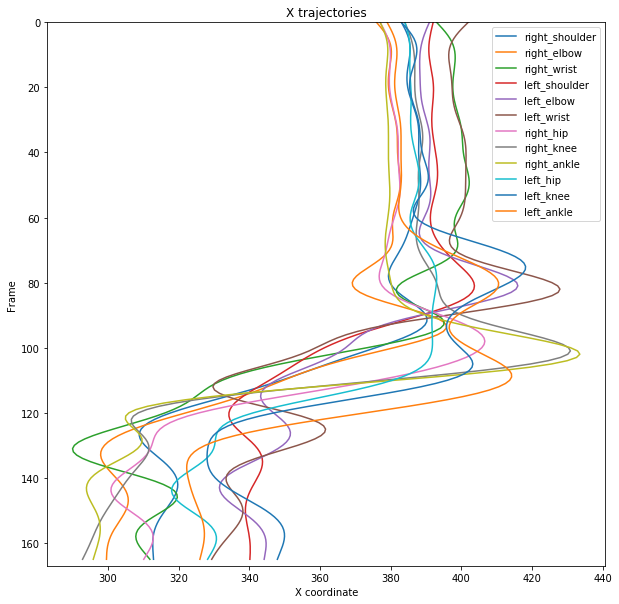

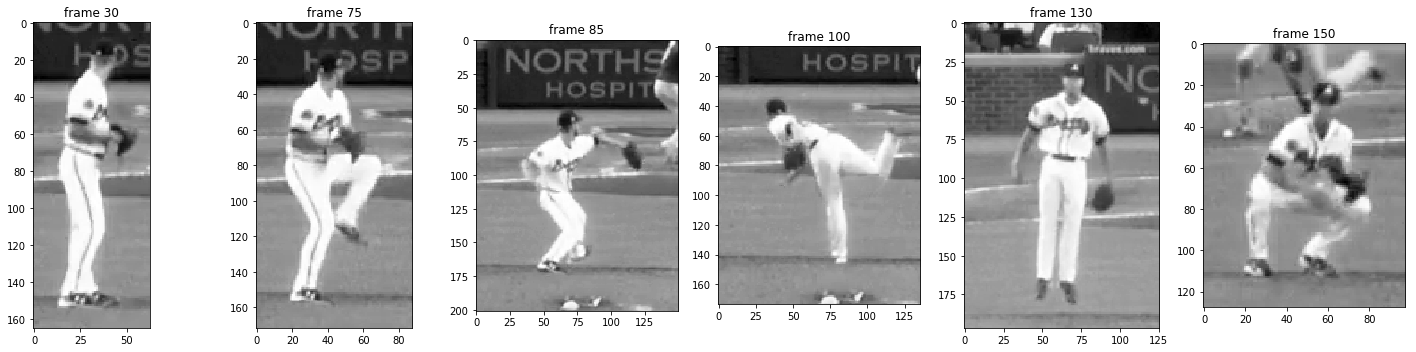

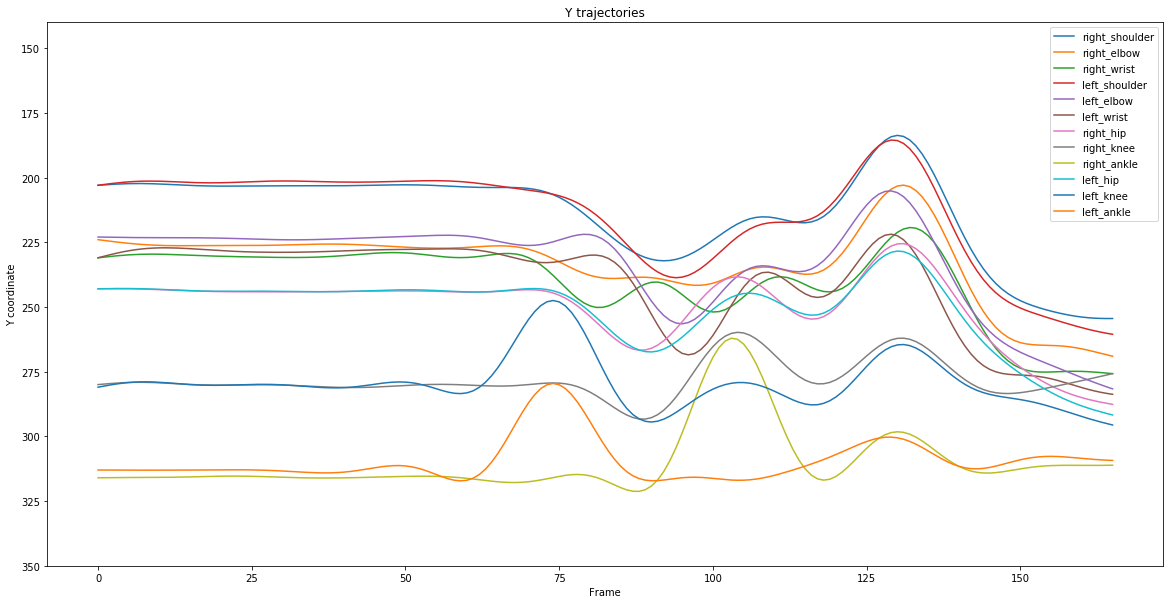

In [4]:
for video, person in zip(["videos_b", "videos_p"], ["batter", "pitcher"]):
    print("--------------------", person, "------------------------")
    plt.figure(figsize = (10,10))
    for j in joints_list[:12]:
        plt.plot(eval(person)[:,joints_list.index(j), 0], np.arange(0,len(eval(person)),1), label = j)
    plt.title("X trajectories")
    plt.ylim(167,0)
    plt.ylabel("Frame")
    plt.xlabel("X coordinate")
    plt.legend()
    plt.show()

    # Plot video frames to visualize maxima in X coordinates
    show_frames = [30, 75, 85, 100, 130, 150]
    fig = plt.figure(figsize=(20, 5))
    for ind, i in enumerate(show_frames):
        ax = fig.add_subplot(1,len(show_frames),ind+1)
        plt.imshow(eval(video)[i])
        plt.title("frame "+str(i))
        plt.gray()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (20,10))
    for j in joints_list[:12]: #[one_joint]: 
        plt.plot(eval(person)[:,joints_list.index(j), 1], label = j)
    plt.legend()
    plt.ylim(350, 140)
    plt.ylabel("Y coordinate")
    plt.xlabel("Frame")
    plt.title("Y trajectories")
    plt.show()

## Release frame: 

First neural network has sequence of 100 frames joint trajectory as input and 
detectes from joints which one is most likeley to be the release frame

Second neural network outputs probability for a single IMAGE to be a release position, and outputs the one with highest probability as the release frame

INFO:tensorflow:Restoring parameters from saved_models/release_frame_smooth
INFO:tensorflow:Restoring parameters from saved_models/release_frame_smooth
INFO:tensorflow:Restoring parameters from saved_models/release_frame_smooth
[78, 86, 112] model smooth mean 92.0
INFO:tensorflow:Restoring parameters from saved_models/release_frame_general
INFO:tensorflow:Restoring parameters from saved_models/release_frame_general
INFO:tensorflow:Restoring parameters from saved_models/release_frame_general
[80, 90, 90] model general mean 86.6666666667
INFO:tensorflow:Restoring parameters from saved_models/release_frame_minmax
INFO:tensorflow:Restoring parameters from saved_models/release_frame_minmax
INFO:tensorflow:Restoring parameters from saved_models/release_frame_minmax
[84, 81, 87] model minmax mean 84.0
INFO:tensorflow:Restoring parameters from saved_models/release_frame_combined
INFO:tensorflow:Restoring parameters from saved_models/release_frame_combined
INFO:tensorflow:Restoring parameters f

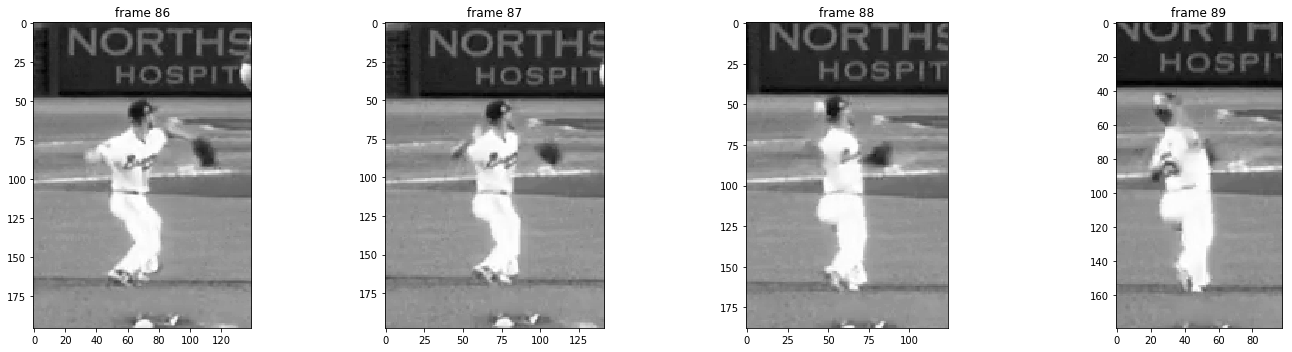

session started
INFO:tensorflow:Restoring parameters from saved_models/release_model
session restored
end of video capture
---- Image release position approach:  92 --------


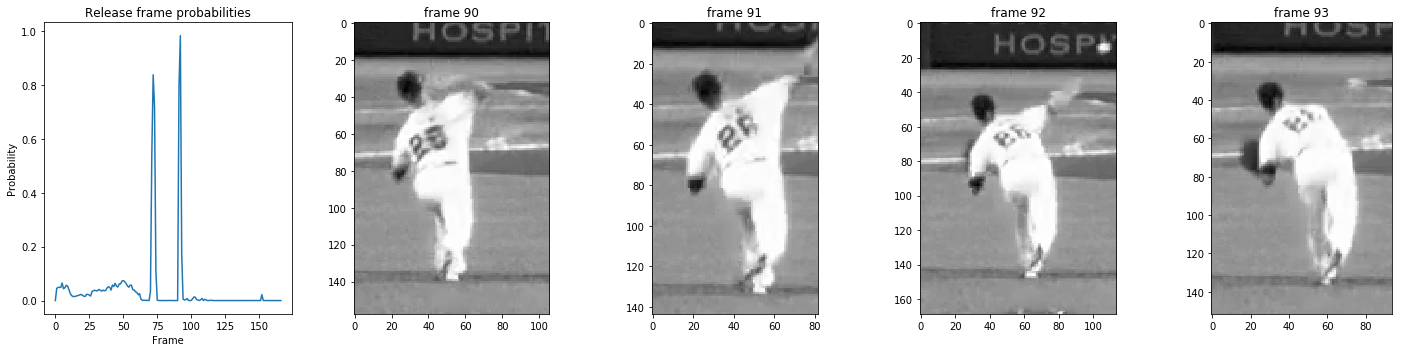

INFO:tensorflow:Restoring parameters from saved_models/release_model
---- Release frame from trajectories approach:  0.190059 --------


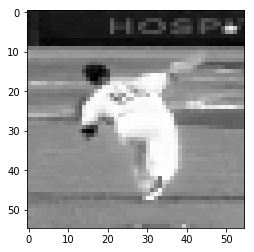

might be a lower value because format of saved videos_p array is different from the normal region of interest, it is recommended to take the first frame with prob >0.1 of a new video as the release frame


In [5]:
# RELEASE FROM TRAJECTORIES APPROACH

# Testing different models and different cut offs (network is not very consistent)
for modl in ["smooth", "general", "minmax", "combined"]:
    l = []
    for i in range(20, 50, 10):
        # needs to be cut to length 100
        release_from_trajectory = release_frame_conv_net(np.array([pitcher[i:i+100]]), 
                            model = "saved_models/release_frame_"+modl)
        l.append(release_from_trajectory[0,0]+i)
    print(l, "model", modl, "mean", np.mean(l))

release_from_trajectory = int(np.mean(l))
print("---- Release frame from trajectories approach: ", release_from_trajectory, "--------")
# Plot
show_frames = range(release_from_trajectory-2, release_from_trajectory+2)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()


# IMAGE RELEASE POSITION APPROACH

video_file = example+".mp4"

# For the image classification, a region of interest is required / helpful
for i in open(video_file+".dat").readlines():
        datContent=ast.literal_eval(i)        
bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']

box = [left_p, right_p, top_p, bottom_p] # bounding box 

# RUN Release frame from video function
release_from_video, release_probs = release_frame_2Dfrom_video(video_file, bbox = box, model = "saved_models/release_model")

print("---- Image release position approach: ", release_from_video, "--------")
# Plot
show_frames = range(release_from_video-2, release_from_video+2)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,len(show_frames)+1,1)
plt.plot(release_probs)
plt.title("Release frame probabilities")
plt.xlabel("Frame")
plt.ylabel("Probability")
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames)+1,ind+2)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# FOR SINGLE IMAGE CLASSIFICATION: no extra function, just use test
release_image = np.array(videos_p[release_from_video])
input_release_frame = cv2.resize(release_image,(55, 55), interpolation = cv2.INTER_LINEAR)/255
data = np.reshape(input_release_frame, (1, 55, 55, 1))
lab, out = test(data, "saved_models/release_model")
release_probability_from_image = out[0,1]
print("---- Release frame from trajectories approach: ", release_probability_from_image, "--------")
plt.imshow(input_release_frame)
plt.show()
print("might be a lower value because format of saved videos_p array is different from the normal region of interest, it is recommended to take the first frame with prob >0.1 of a new video as the release frame")

# Batter's first movement: gradient and neural network method

10 40
INFO:tensorflow:Restoring parameters from saved_models/batter_first_rnn_10_40
--------------START RUN: network: 127 , gradient:  <function first_move_gradient at 0x132c2a268> ------------------


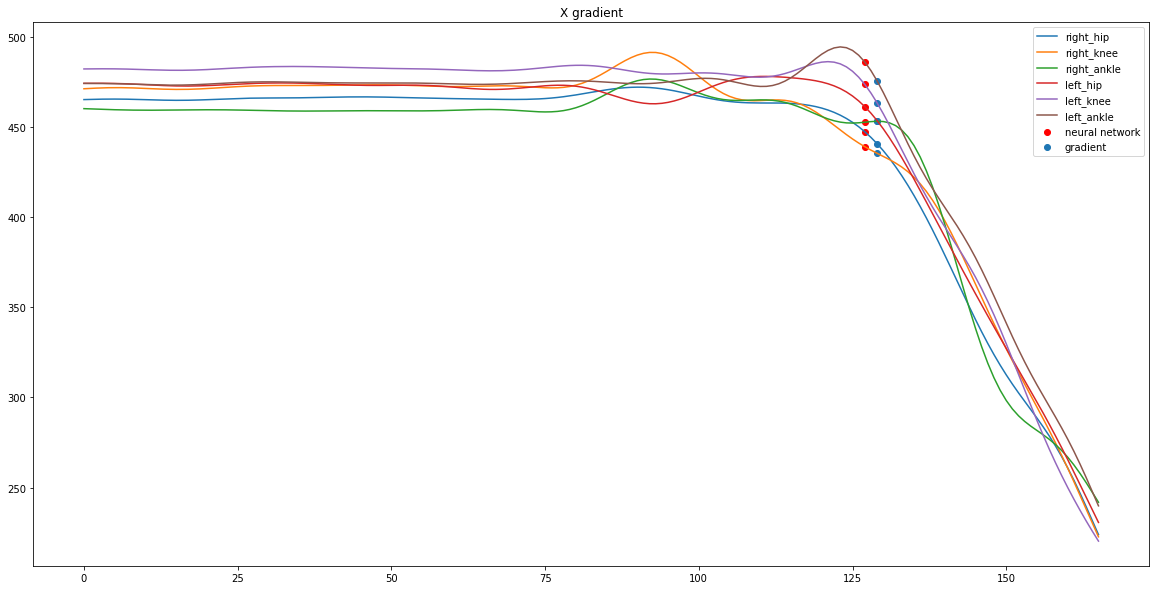

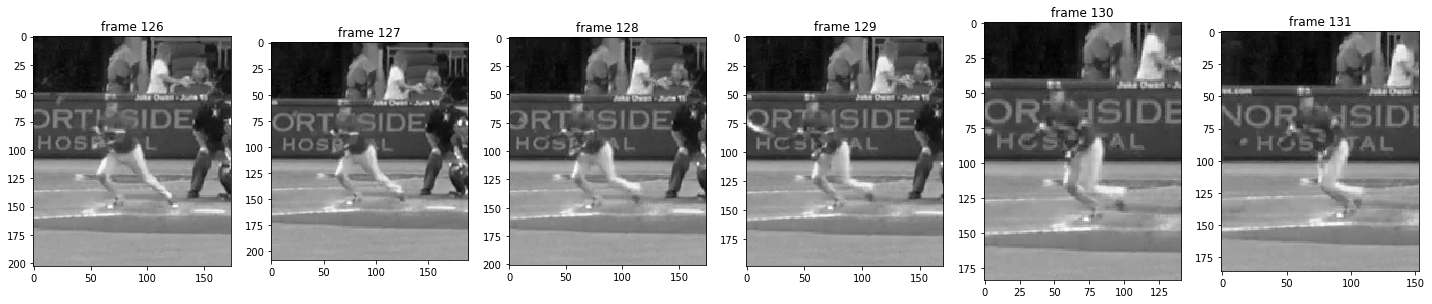

In [6]:
# gradient method
first_batter_gradient = first_move_gradient(batter)
# neural network
first_move_nn = first_move_batter_NN(np.array([batter]), [90], model = "saved_models/batter_first_rnn_10_40")[0] # LATER HERE RELEASE FRAME
print("--------------START RUN: network:", first_move_nn, ", gradient: ", first_move_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in joints_list[6:12]:
    plt.plot(batter[:,joints_list.index(j), 0], label = j)
plt.scatter([first_move_nn for _ in range(6)], batter[first_move_nn, 6:12, 0],  label = "neural network", color = "red")
plt.scatter([first_batter_gradient for _ in range(6)], batter[first_batter_gradient, 6:12, 0], label = "gradient")
plt.legend()
plt.title("X gradient")
plt.show()

show_frames = range(first_batter_gradient-3, first_batter_gradient+3)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

### Moment batter puts foot down

in function: first step 127 foot highest 91 foot down 100
first step 127 foot highest 91 foot down 100
--------------moment batter puts foot down 100 ------------------


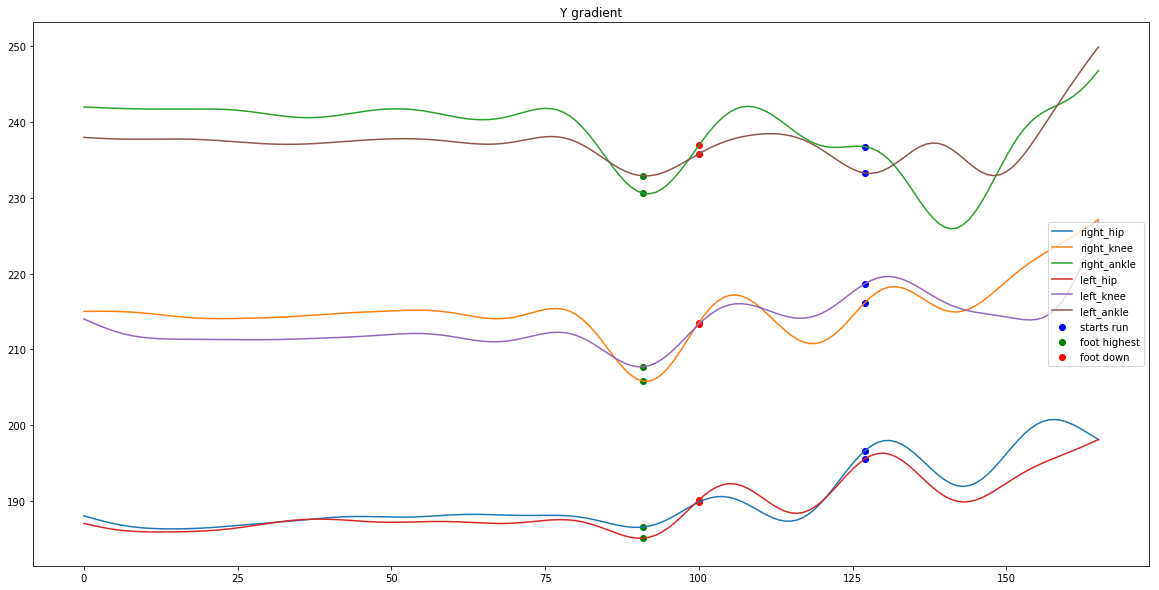

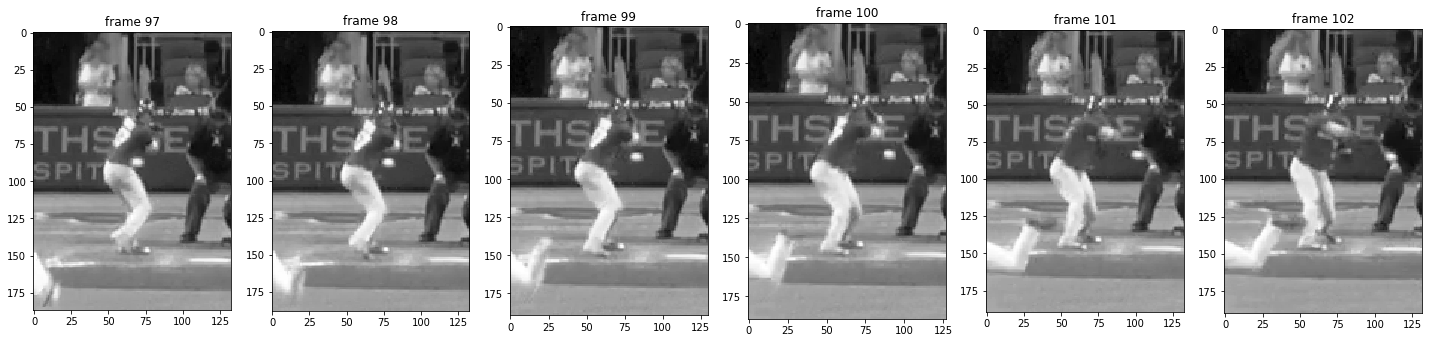

In [7]:
relevant_joints =[7,8,10,11]

foot_up, foot_down_gradient = foot_to_ground(batter, release= release_from_video, start_run = first_move_nn)
    
print("first step", first_move_nn, "foot highest", foot_up, "foot down", foot_down_gradient)

print("--------------moment batter puts foot down", foot_down_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in joints_list[6:12]:
    plt.plot(batter[:,joints_list.index(j), 1], label = j)
plt.scatter([first_move_nn for _ in range(6)], batter[first_move_nn, 6:12, 1],  label = "starts run", color = "blue")
plt.scatter([foot_up for _ in range(6)], batter[foot_up, 6:12, 1],  label = "foot highest", color = "green")
plt.scatter([foot_down_gradient for _ in range(6)], batter[foot_down_gradient, 6:12, 1],  label = "foot down", color = "red")
plt.legend()
plt.title("Y gradient")
plt.show()

show_frames = range(foot_down_gradient-3, foot_down_gradient+3)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Fast moving object detection - for pitcher's first movement, ball detection and ball release frame

In [8]:
from fom_detection import *

##  Release frame and ball trajectory

works better with side view video, because green background for ball detection


RELEASE FRAME AT  98.0 



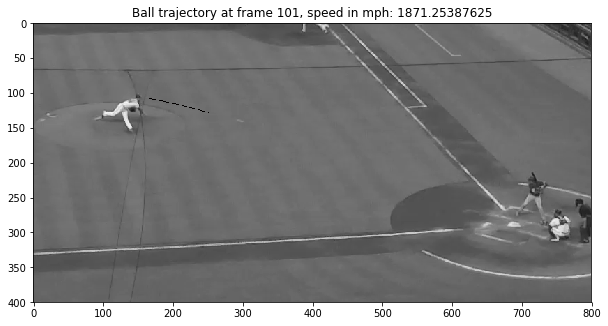

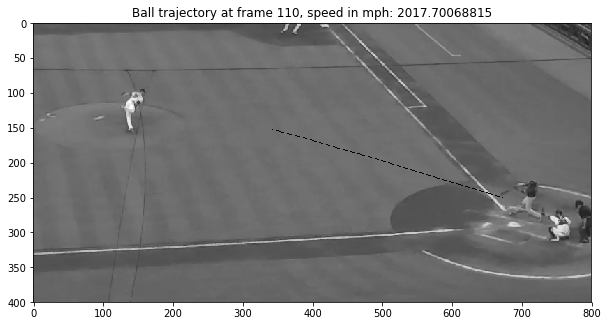

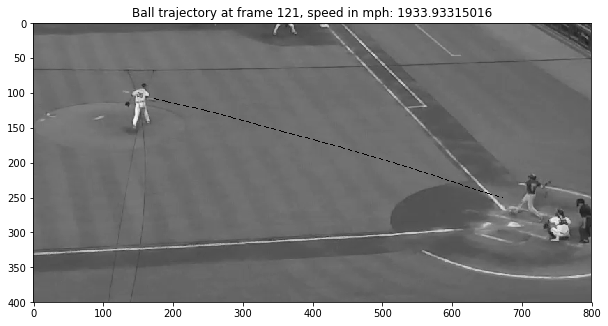

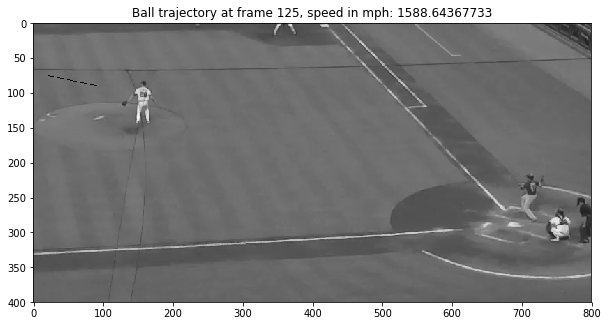


output: 98.0 [[163.5, 107.0], [207.5, 116.5], [252.0, 128.5], [342.0, 152.5], [388.0, 164.5], [434.0, 178.5], [481.5, 191.5], [529.0, 206.0], [577.0, 221.0], [624.5, 235.5], [673.5, 250.5], [673.5, 250.5], [639.0, 240.5], [589.5, 223.0], [540.0, 207.5], [490.0, 192.5], [442.5, 178.5], [395.0, 165.0], [350.0, 153.0], [303.5, 140.0], [260.0, 128.5], [217.5, 118.0], [173.0, 108.0], [94.5, 90.0], [55.0, 82.0], [18.5, 74.0]]
The release frame predicted above is correct, althought 98 != 92, because center field camera and side view camera are not synchronized


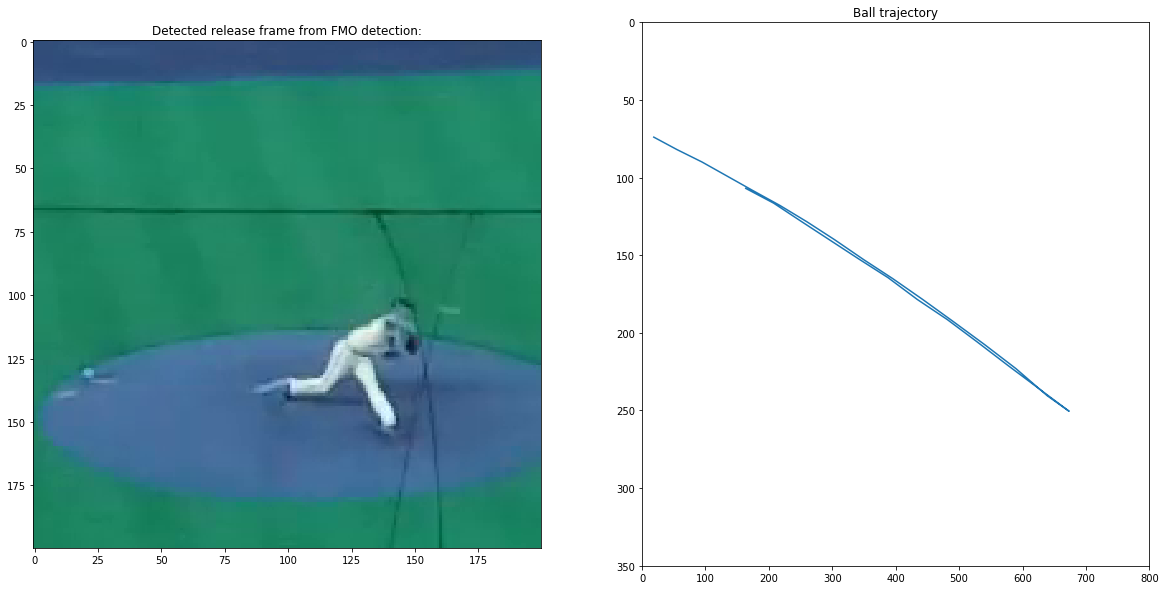

In [9]:
BASE = example+".m4v"
box = [400, 800, 600, 1400]
ball_release, ball_trajectory, _ = detect_ball(BASE, joints_array = None, plotting=False, min_area=30, every_x_frame=4, roi=box)
print("output:", ball_release, ball_trajectory.tolist())
print("The release frame predicted above is correct, althought 98 != 92, because center field camera and side view camera are not synchronized")

plt.figure(figsize = (20,10))
cap = cv2.VideoCapture(example+".m4v")
p=0
while True:
    ret, frame = cap.read()
    if p==ball_release:
        plt.subplot(1,2,1)
        plt.imshow(frame[400:600, 600:800])
        plt.title("Detected release frame from FMO detection:")
        break
    p+=1
    
plt.subplot(1,2,2)
plt.plot(ball_trajectory[:,0], ball_trajectory[:,1])
plt.ylim(350, 0)
plt.xlim(0, 800)
plt.title("Ball trajectory")
plt.show()

# Pitcher's first movement:

### with FMO detection and with gradient
FMO detection for pitcher's first movement: better with center field video (and in this notebook only pose estimation for center field video is used)

Definition for pitcher's first movement: highest point of his leg when lifting his leg (then the video can be saved from 10 frames before

changes to fmo detection for release frame:
* joints array used (approach works by looking for FMO detections close to knee/ankle in some consecutive frames)
* bigger min_area used
* no roi required
* every_x_frame = 4 means that only every fourth frame is compared, such that slower movements are detected than for the ball

first movement frame:  69


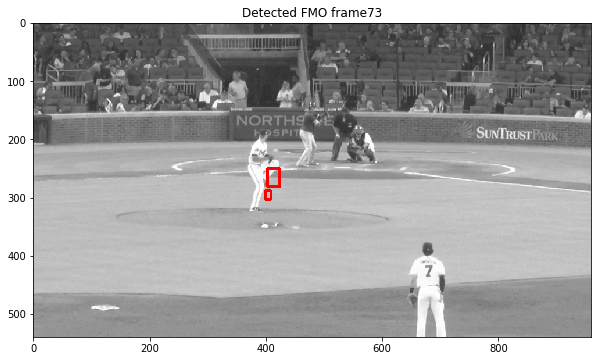

First movement (possibly refined) 74


In [10]:
BASE = example+".mp4"
#tic = time.time()
_, _, first_move_frame = detect_ball(BASE, joints_array = pitcher, plotting=False, min_area=50, every_x_frame=4)
#print("performance is real time: time for 70 frames with plotting:", time.time()-tic)

--------------START RUN: FMO detection: 74 , gradient:  78 ------------------


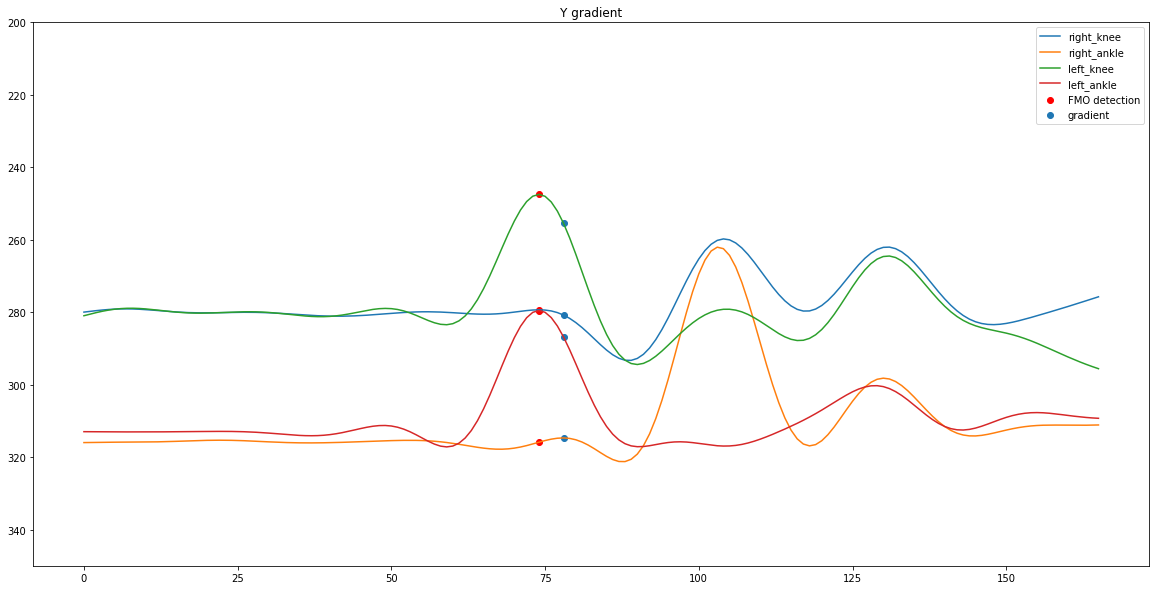

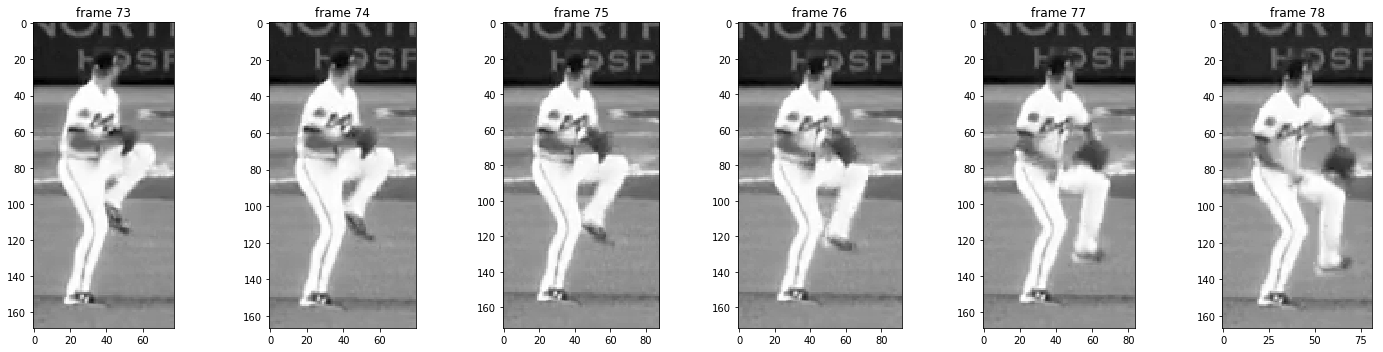

In [11]:
# changes to batter: 
# relevant_coordinate: Y coordinate (because lifting of leg) 
# relevant_joints_list: only knees and ankles
relevant_joints =[7,8,10,11]
first_pitcher_gradient = first_move_gradient(pitcher, relevant_joints_list=relevant_joints, relevant_coordinate=1, cutoff=2)


print("--------------START RUN: FMO detection:", first_move_frame, ", gradient: ", first_pitcher_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in np.array(joints_list)[[relevant_joints]]:
    plt.plot(pitcher[:,joints_list.index(j), 1], label = j)
plt.scatter([first_move_frame for _ in range(len(relevant_joints))], pitcher[first_move_frame, relevant_joints, 1],  label = "FMO detection", color = "red")
plt.scatter([first_pitcher_gradient for _ in range(len(relevant_joints))], pitcher[first_pitcher_gradient, relevant_joints, 1], label = "gradient")
plt.legend()
plt.title("Y gradient")
plt.ylim(350, 200)
plt.show()

show_frames = range(first_pitcher_gradient-5, first_pitcher_gradient+1)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Timeline - all together

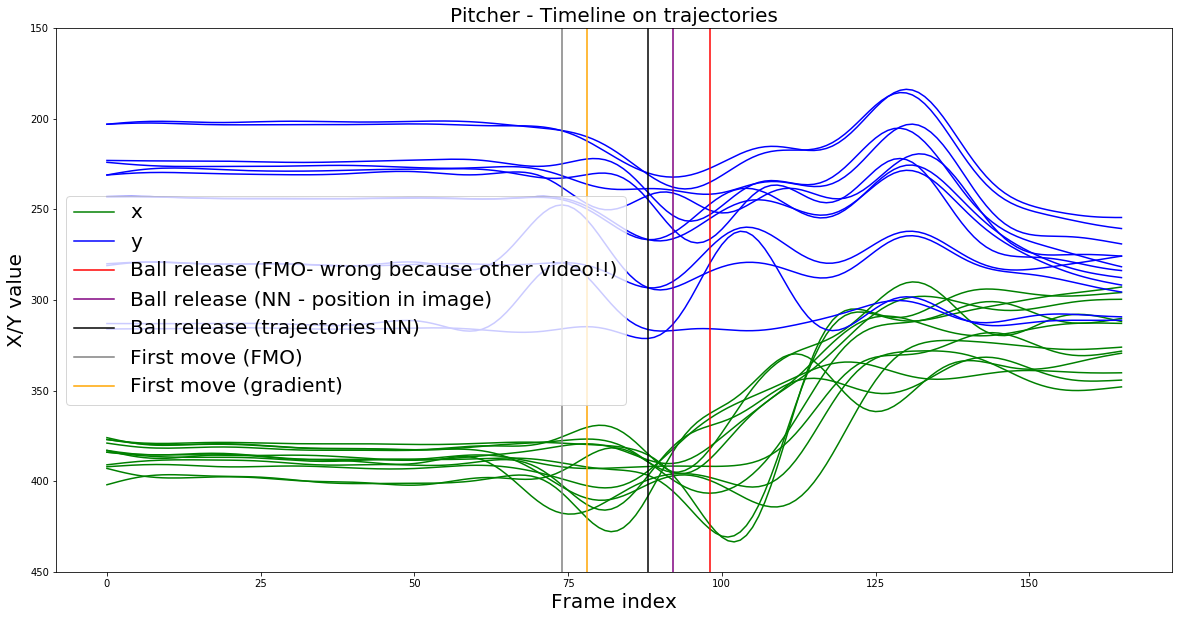

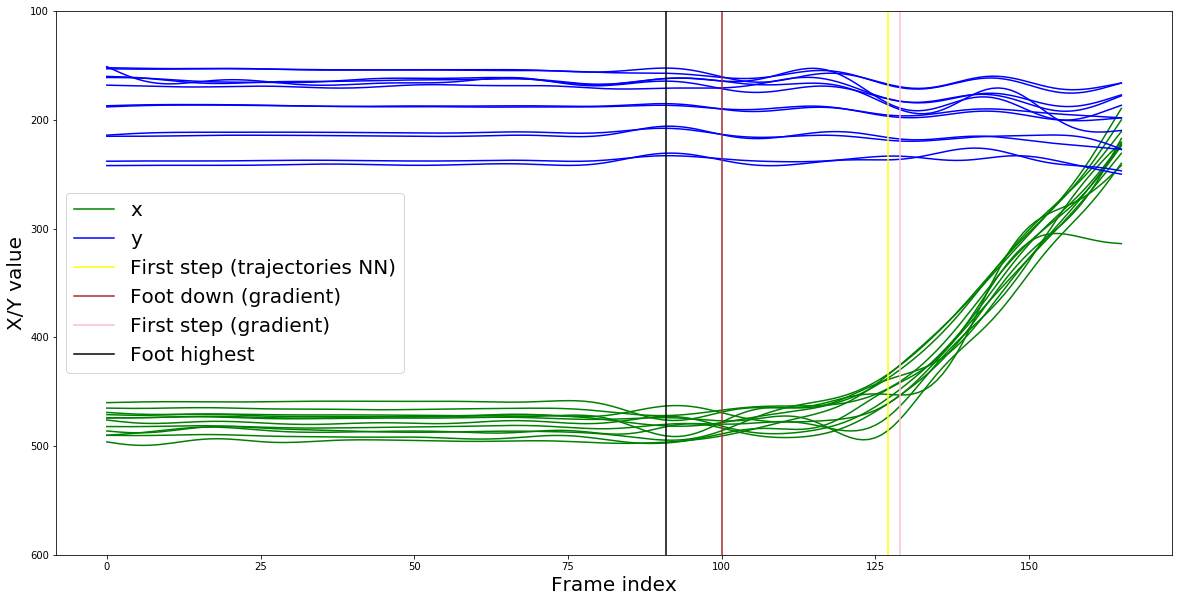

In [12]:
pitcher_events = {"First move (FMO)": first_move_frame, "First move (gradient)": first_pitcher_gradient,
                 "Ball release (FMO- wrong because other video!!)": ball_release, "Ball release (trajectories NN)": release_from_trajectory,
                 "Ball release (NN - position in image)": release_from_video}
batter_events = {"Foot highest": foot_up, "Foot down (gradient)": foot_down_gradient, 
                "First step (gradient)": first_batter_gradient, "First step (trajectories NN)": first_move_nn}
col=["green", "blue","red", "purple","black", "gray", "orange", "yellow", "brown", "pink", "black"]
co = ["x","y"]
# PITCHER
limits = [450, 150]
plt.figure(figsize = (20,10))
for j in [0,1]:
    plt.plot(pitcher[:,:, j], label = co[j], color = col[j])
for i, event in enumerate(list(pitcher_events.keys())):
    plt.plot([pitcher_events[event], pitcher_events[event]], limits, color=col[i+2], label=event)
plt.legend(fontsize=20)
plt.title("Pitcher - Timeline on trajectories", fontsize=20)
plt.ylim(limits[0], limits[1])
plt.ylabel("X/Y value", fontsize=20)
plt.xlabel("Frame index", fontsize=20)
plt.show()

# BATTER foot_up, foot_down_gradient first_move_gradient first_move_nn
limits = [600, 100]
plt.figure(figsize = (20,10))
for j in [0,1]:
    plt.plot(batter[:,:, j], label = co[j], color = col[j])
for i, event in enumerate(list(batter_events.keys())):
    plt.plot([batter_events[event], batter_events[event]], limits, color=col[i+7], label=event)
plt.legend(fontsize=20)
# plt.title("Batter - Timeline on trajectories")
plt.ylim(limits[0], limits[1])
plt.ylabel("X/Y value", fontsize=20)
plt.xlabel("Frame index", fontsize=20)
plt.show()

In [13]:
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
pitcher_array = np.roll(pitcher, 2, axis = 1)
batter_array = np.roll(batter, 2, axis = 1)

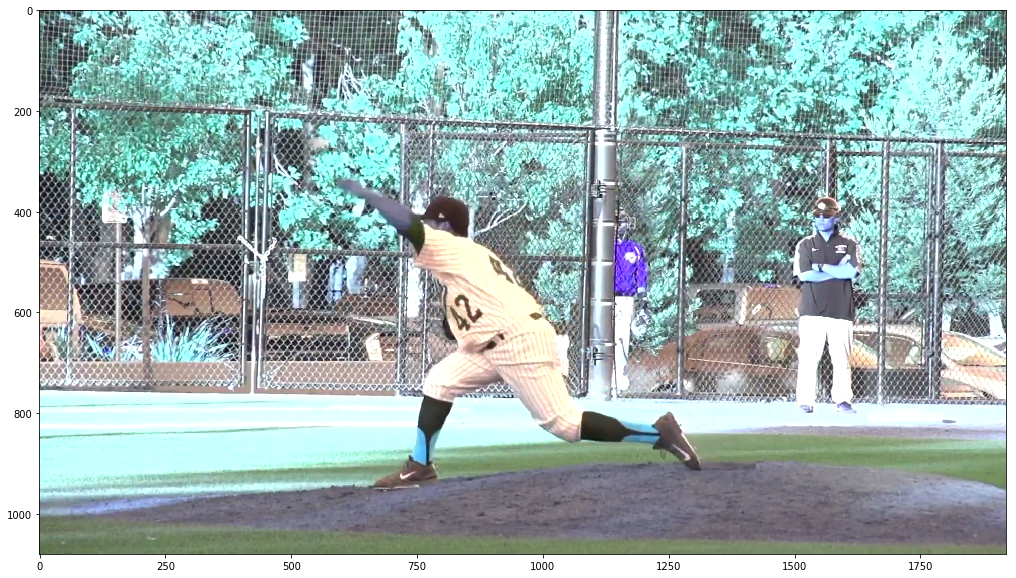

In [14]:
cap = cv2.VideoCapture("/Volumes/Nina Backup/high_quality_testing/pitcher/#42 LHP Michael Chavez.mp4") #26 RHP Tim Willites (2).mp4") #example+".mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 470)
_, canvas = cap.read()
plt.figure(figsize=(20,10))
plt.imshow(canvas)
plt.savefig("canvas")
plt.show()

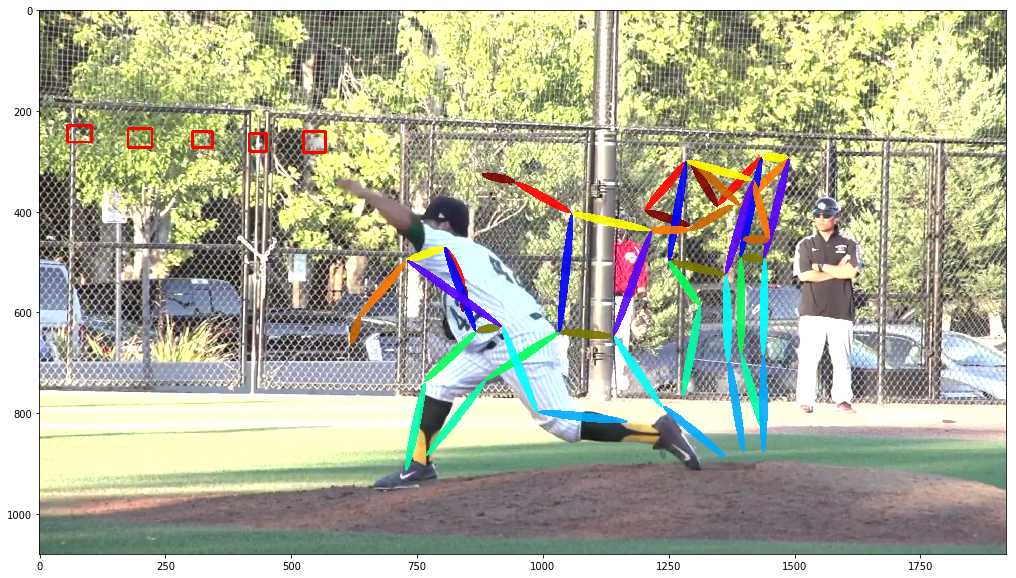

In [15]:
import math
limbSeq = [[0,1], [1,2], [0,3], [3,4], [4,5], [6,9],[6,7], [7,8],[9,10],[10,11], [0,6], [3,9]]
stickwidth = 8
colors = [[255, 0, 0], [120, 0, 0], [255, 255, 0], [255, 120, 0], [200, 100, 0], [120, 120, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cap = cv2.VideoCapture("/Volumes/Nina Backup/high_quality_testing/pitcher/#42 LHP Michael Chavez.mp4") #26 RHP Tim Willites (2).mp4") #example+".mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 470)
_, canvas = cap.read()
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
pitcher = from_json("/Volumes/Nina Backup/low_quality_testing/scale0tests/#42 LHP Michael Chavez.json")
plt.figure(figsize =(20,10))
ball_trajectory = [[479, (525, 241), (568, 282)], [480, (416, 245), (451, 280)], [481, (304, 241), (344, 272)], 
                   [482, (176, 235), (224, 272)], [483, (56, 229), (104, 262)]]
frame_list = [0, 400, 450, 490]
for j in range(len(pitcher)):
    if j >=ball_trajectory[0][0] and j<=ball_trajectory[-1][0]:
        cand = ball_trajectory[j-ball_trajectory[0][0]]
        cv2.rectangle(canvas, cand[1], cand[2],[255,0,0], 4)
    if j in frame_list:
        for player in ["pitcher"]:
            for i, inds in enumerate(limbSeq):
                if inds[0]>11 or inds[1]>11:
                    continue
                Y = eval(player)[j,inds, 0]
                X = eval(player)[j,inds, 1]
                mX = np.mean(X)
                mY = np.mean(Y)
                cur_canvas = canvas.copy()
                length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
                angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
                polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
                cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
                canvas = cv2.addWeighted(canvas, 0.1, cur_canvas, 0.9, 0)
plt.imshow(canvas)
plt.show()

In [87]:
csv = pd.read_csv("outputs/a_report.csv", delimiter=";") # speed2

In [88]:
print(csv.columns.tolist())

['sportvision_pitch_id', 'sportvision_speed_at_50_feet', 'linear_regression_start_speed', 'linear_regression_error', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'Unnamed: 14']


In [89]:
labels = csv["sportvision_speed_at_50_feet"].values
print("number of videos", labels.shape)
out = csv["linear_regression_start_speed"].values
col = csv['sportvision_pitch_id'].values
nr_videos = len(out)
inds = np.where(np.isnan(out))
missing = len(inds[0])
labels = np.delete(labels, inds)
out = np.delete(out, inds)
col = np.delete(col, inds)
print(out.shape)
print(labels.shape)
print(np.amax(out), np.amin(out))
print("isnan von data", missing/nr_videos)

number of videos (337,)
(331,)
(331,)
96.7111 70.1945
isnan von data 0.017804154302670624


In [90]:
print(len(labels), len(out), len(col))

331 331 331


mean error 2.55562628399 error standard deviation 1.75057203899 max 11.5699 min 0.00320000000001 MSE 9.5957281671
shifted, not randomized around 0 because mean error 2.22690181269


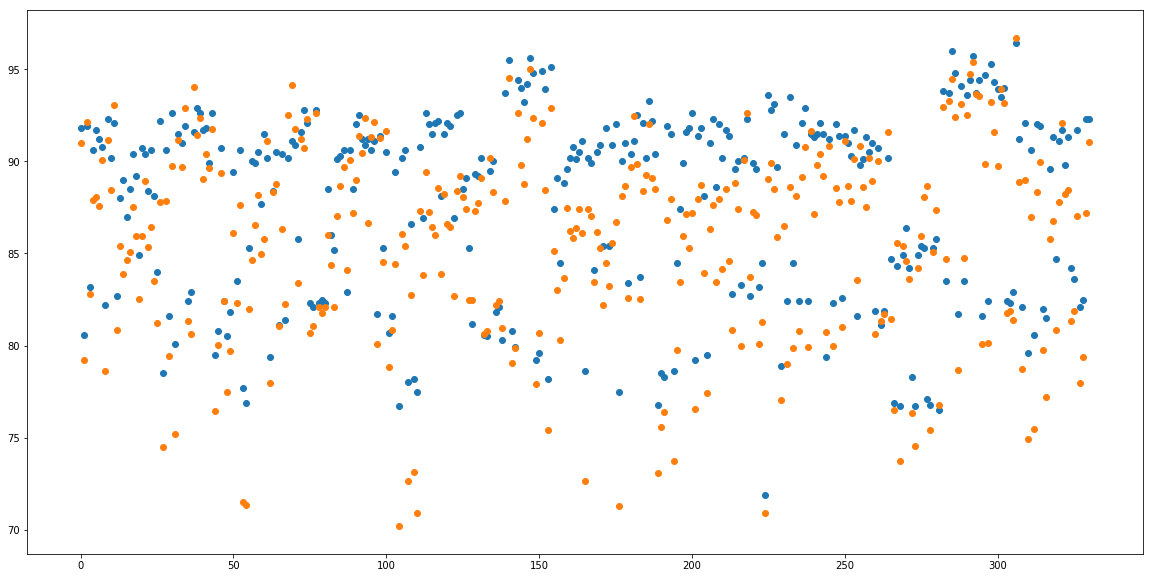

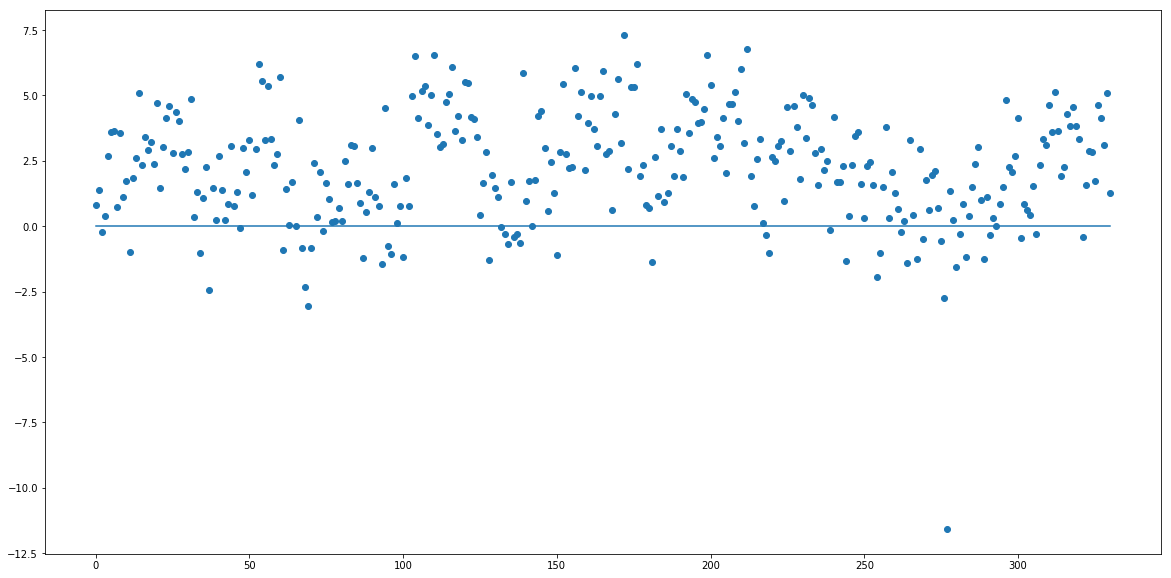


['160930_220317']
(array([277]),)
330
mean error 2.52831030303 error standard deviation 1.68131167331 max 7.3095 min 0.00320000000001 MSE 9.21916193121
shifted, not randomized around 0 because mean error 2.26871030303


In [91]:
deviation = labels-out
error = np.absolute(deviation)
print("mean error", np.mean(error), "error standard deviation", np.std(error), "max", np.amax(error), "min", np.amin(error), "MSE", np.mean(error**2))
print("shifted, not randomized around 0 because mean error", np.mean(deviation))
# print(labels-out)
plt.figure(figsize=(20,10))
plt.scatter(np.arange(len(labels)), labels)
plt.scatter(np.arange(len(out)), out)
plt.show()
plt.figure(figsize=(20,10))
plt.scatter(np.arange(len(labels)), labels-out)
plt.plot(np.arange(len(labels)), np.zeros(len(labels)))
plt.show()
print()
print(col[np.where(error>10)])
print(np.where(error>8))
# print(col[150])

new = deviation[np.where(error<8)]
error = np.absolute(new)
print(len(new))
print("mean error", np.mean(error), "error standard deviation", np.std(error), "max", np.amax(error), "min", np.amin(error), "MSE", np.mean(error**2))
print("shifted, not randomized around 0 because mean error", np.mean(new))

In [59]:
col = csv['sportvision_pitch_id'].values
col = np.delete(col, inds)
print(len(col))
nr_videos = len(out)
inds = np.where(np.isnan(out))
print(col[inds].tolist())

inds = np.where(out>100)
print(out[inds])
labels = np.delete(labels, inds)
out = np.delete(out, inds)
too_high = len(inds[0])
inds = np.where(out<60)
print(out[inds])
labels = np.delete(labels, inds)
out = np.delete(out, inds)
too_low = len(inds[0])
print("outliers <60 or >100: ", too_low, too_high, (too_low+too_high)/(nr_videos-missing))

['160930_192940', '160930_193009', '160930_193053', '160930_193126', '160930_193143', '160930_193325', '160930_193410', '160930_193521', '160930_193542', '160930_193923', '160930_193937', '160930_194037', '160930_194052', '160930_194154', '160930_194213', '160930_194235', '160930_194341', '160930_194717', '160930_194813', '160930_194835', '160930_194934', '160930_195017', '160930_195109', '160930_195143', '160930_195251', '160930_195357', '160930_195416', '160930_195657', '160930_200009', '160930_200026', '160930_200436', '160930_200458', '160930_200612', '160930_200650', '160930_200757', '160930_200914', '160930_200933', '160930_201356', '160930_201744', '160930_201948', '160930_202010', '160930_202034', '160930_202143', '160930_202222', '160930_202315', '160930_202340', '160930_202439', '160930_202501', '160930_202552', '160930_202724', '160930_203016', '160930_203106', '160930_203131', '160930_203313', '160930_203335', '160930_203422', '160930_203443', '160930_203507', '160930_20353

In [75]:
4/182

0.02197802197802198

In [76]:
a = [1,2,3]
b = [4,5,6]
print(a+b)

[1, 2, 3, 4, 5, 6]
